In [158]:
# data wrangling
import re # regular expressions!

# math and data utilities
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set-up default visualization parameters
viz_dict = {
    'figure.figsize':[16, 10],
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")


## Initial Setup
We can download the data from kaggle to our data folder using the command line: 

`kaggle competitions download -c titanic`

`unzip titanic.zip`

After that, let's get the data into some Pandas dataframes:

In [159]:
train_df = pd.read_csv('data/train.csv', index_col='PassengerId')
test_df = pd.read_csv('data/test.csv', index_col='PassengerId')

train_df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Lets combine the two dataframes so that we can preprocess all of the data at once.

We will first pop the 'Survived' column from the training data and save it for later. We also want to save indexes of the training/testing dataframes so that we can split them apart again.

In [160]:
survival = train_df.pop('Survived')
train_idx, test_idx = train_df.index, test_df.index

df = pd.concat([train_df, test_df])

# clear memory, now that we don't need these two df's:
del train_df, test_df

# Exploritory Data Analysis:

In [161]:
# let's take a look at the first fiew entries of our data:
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Is there any missing data? 
We can see if we are missing any data in our columns by comparing Non-Null Count to the total number of entries. For example, we see below that Age has 1046 Non-Null entries out of a total of 1309 total. That means it's missing 263 data points for Age.

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 112.5+ KB


### Can we find new and useful ways of describing the same data (Feature Engineering)?

For example, looking at family data, we can tell if a person traveled alone, or with family. We can also determine how many people, if any they travelled with. Let's add these features to our dataframe.

In [163]:
df['FamilySize'] = 1 + df.SibSp + df.Parch
df['Alone'] = df.FamilySize.apply(lambda x: 1 if x==1 else 0)

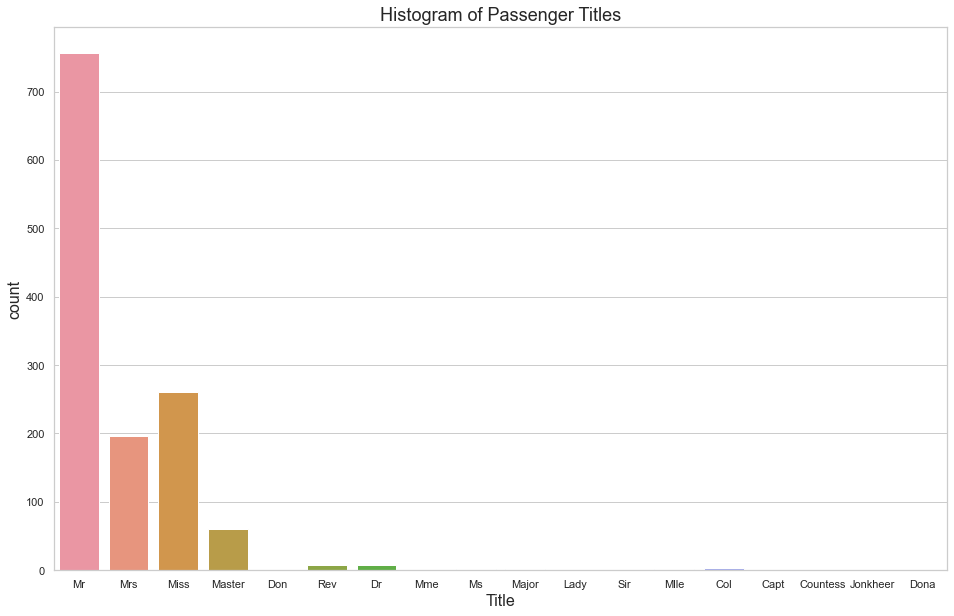

In [164]:
# extract last names and titles:
# The regular expression ([A-Za-z]+) searches for and returns any groups of letters of 
# upper or lower case. The '+' indicates to return any group that occurs 1 or more times
df['Title'] = df.Name.str.extract(r'([A-Za-z]+)\.')

# extract last name: 
sns.countplot(df.Title).set_title("Histogram of Passenger Titles")
df['LName'] = df.Name.str.extract(r'([A-Za-z]+),')


In [165]:
# Many of these names mean similar things, so let's simplify.

title_dict = {
    'Mrs': 'Mrs', 'Lady': 'Lady', 'Countess': 'Lady',
    'Jonkheer': 'Lord', 'Col': 'Officer', 'Rev': 'Officer',
    'Miss': 'Miss', 'Mlle': 'Miss', 'Mme': 'Miss', 'Ms': 'Miss', 'Dona': 'Lady',
    'Mr': 'Mr', 'Dr': 'Officer', 'Major': 'Officer', 'Capt': 'Officer', 'Sir': 'Lord', 'Don': 'Lord', 'Master': 'Master'
}

df.Title = df.Title.map(title_dict)

And here is a countplot of our titles after we have translanted them with our dictionary:

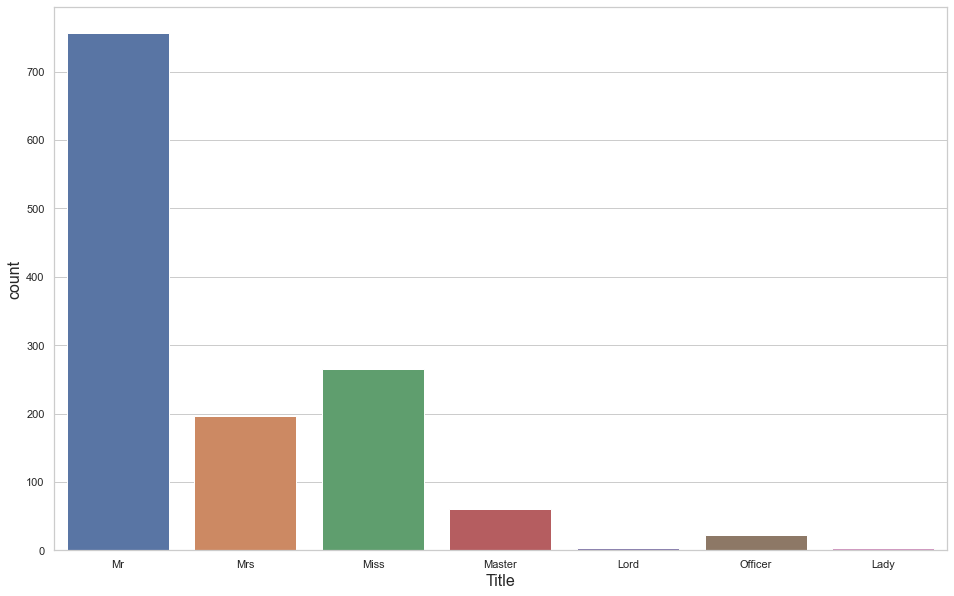

In [166]:
sns.countplot(df.Title)

In [167]:
# Display the numbers behind the visualization: 
df.Title.value_counts()

Mr         757
Miss       265
Mrs        197
Master      61
Officer     23
Lady         3
Lord         3
Name: Title, dtype: int64

## Filling in missing Age data:
We might suspect that age is correlated to title. For example, the title "Master" means "boy". We also know that during this era, women typically married earlier in life, implying that a women carrying the title "Miss" might be younger than a "Mrs". We also know that it was more socially acceptable for young women to marry men much older than themselves. These insights may be useful, and we can see if they apply to this particular data set.

Let's explore this concept by looking at the distribution of missing age value by title, and then making some visualizations:

In [168]:
# distribution of missing ages:
df.Title[df.Age.isnull()].value_counts()

Mr         176
Miss        51
Mrs         27
Master       8
Officer      1
Name: Title, dtype: int64

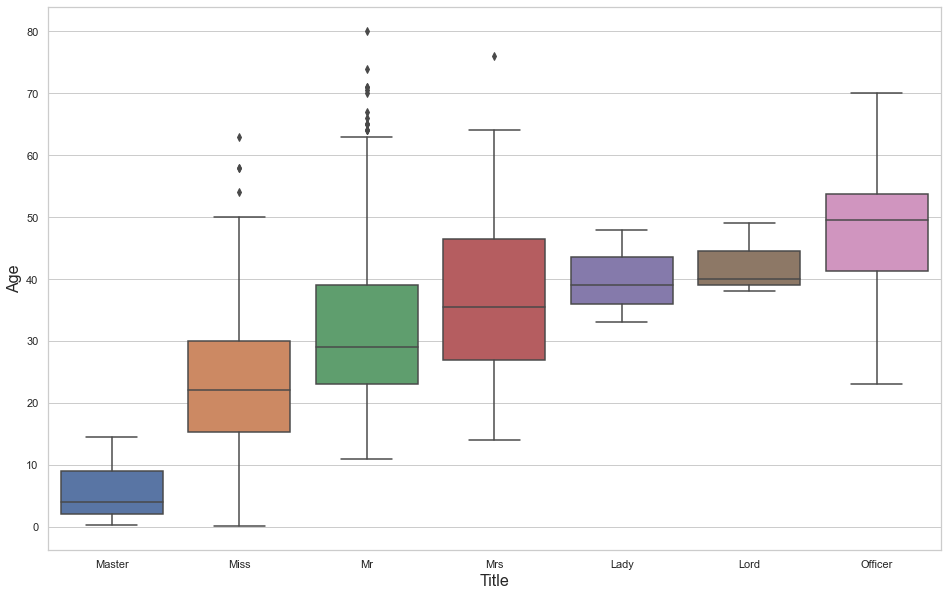

In [169]:
# box plot of title vs age, in order of increasing median
sns.boxplot(x='Title', y='Age', data=df, order=['Officer', 'Lord', 'Lady', 'Mrs', 'Mr', 'Miss', 'Master'][::-1])

### Findings
Indeeed, it appears that we can order median age by title. We can use this information to fill in our missing age values according to the average age of a title. Let's take a look at how to do that. 

Our algorithm should look something like this:

__Loop over titles:__

  - __Step 1:__ Compute the average age of all those who hold this title
    
  - __Step 2:__ Find each entry containing this title with no age data.
    
  - __Step 3:__ Add average age from step 1 to these entries. 

In [170]:
# Here is a passenger whose age information is missing:
df.loc[1305]

Pclass                         3
Name          Spector, Mr. Woolf
Sex                         male
Age                          NaN
SibSp                          0
Parch                          0
Ticket                 A.5. 3236
Fare                        8.05
Cabin                        NaN
Embarked                       S
FamilySize                     1
Alone                          1
Title                         Mr
LName                    Spector
Name: 1305, dtype: object

In [171]:
# Step 1. for each title, get all rows containing this title where age is null, and the column 'Age'.
# Step 2. From the age column, take the average of all the cells that correspond with current,
# title. 
# Step 3. Fill in the missing data with the average from step 2.

for title in df.Title.unique():
    # get all cells containing this title, with age not null
    df.loc[((df.Age.isnull())&(df.Title==title)), 'Age'] = df.Age[df.Title == title].mean() 

In [172]:
# Let's see if age was succssfully filled in:
df.loc[1305]

Pclass                         3
Name          Spector, Mr. Woolf
Sex                         male
Age                      32.2522
SibSp                          0
Parch                          0
Ticket                 A.5. 3236
Fare                        8.05
Cabin                        NaN
Embarked                       S
FamilySize                     1
Alone                          1
Title                         Mr
LName                    Spector
Name: 1305, dtype: object

Sure enought, we have filled in the missing age data with the average age of all other passengers using the title "Mr".

### Filling in missing ticket Fares

There is only one missing datapoint for fare, but let's see if we can find a way to fill it in anyway. It seems logical that 1st class tickets cost more than 2nd Class and so on. Does the data support this? In order to find out, we will use the same tactic as when looking at age data.

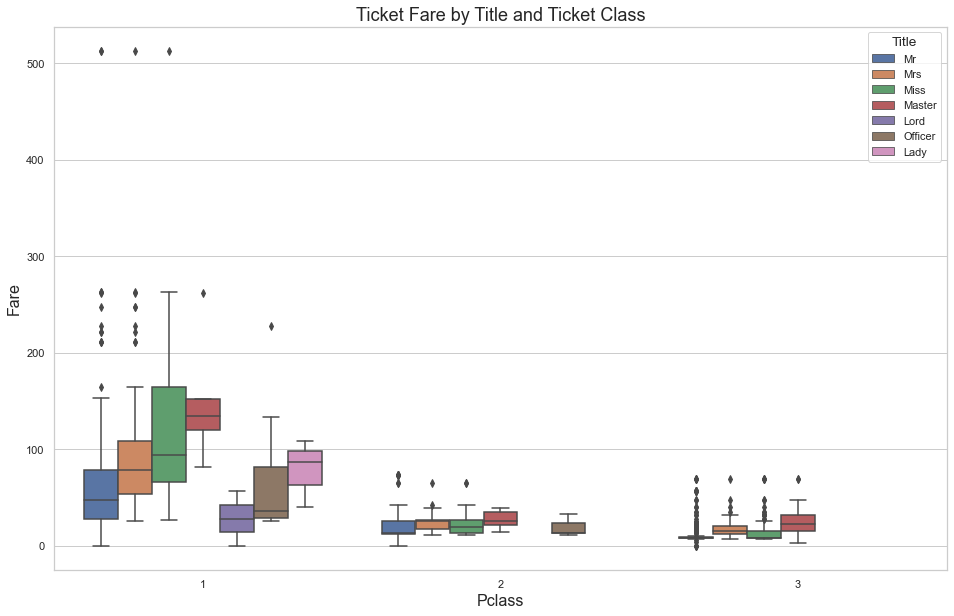

In [178]:
sns.boxplot(x='Pclass', y='Fare', hue='Title', data=df).set_title("Ticket Fare by Title and Ticket Class")
plt.show()

It looks like we can generalize ticket cost by ticket class, which we expected. We can get even more granular, however if we break it down by title... If there was more missing fare data, this might be a good alternative. For now, let's stick with Pclass. 

In [179]:
# Display the single passenger with missing fare data
df.loc[df.Fare.isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Title,LName
PassengerId,,,,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,1,Mr,Storey


In [180]:
# Since Mr. Storey was in 3rd class, lets fill in his fare price with the average third class ticket price:
df.loc[df.Fare.isnull(), 'Fare'] = df.loc[df.Pclass==3, 'Fare'].mean()
df.loc[1044]

Pclass                         3
Name          Storey, Mr. Thomas
Sex                         male
Age                         60.5
SibSp                          0
Parch                          0
Ticket                      3701
Fare                     13.3029
Cabin                        NaN
Embarked                       S
FamilySize                     1
Alone                          1
Title                         Mr
LName                     Storey
Name: 1044, dtype: object

So we see that our missing ticket fare for Mr. Thomas Story is now filled in.

For simplicity's sake, I'm going to drop Ticket, Cabin and Name from the dataframe. I'm guessing that those fields won't have much impact on the prediction.

In [85]:
df.drop(['Ticket', 'Name', 'Cabin'], axis=1, inplace=True)

In [86]:
df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,LName
PassengerId,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,Mr,Braund
2,1,female,38.0,1,0,71.2833,C,Mrs,Cumings
3,3,female,26.0,0,0,7.9250,S,Miss,Heikkinen
4,1,female,35.0,1,0,53.1000,S,Mrs,Futrelle
5,3,male,35.0,0,0,8.0500,S,Mr,Allen
...,...,...,...,...,...,...,...,...,...
1305,3,male,NaN,0,0,8.0500,S,Mr,Spector
1306,1,female,39.0,0,0,108.9000,C,Lady,Ocana
1307,3,male,38.5,0,0,7.2500,S,Mr,Saether
